In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_path = 'datasets/house_final.csv'
house = pd.read_csv(dataset_path)

# Dataset Info

In [3]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageRate,HouseAge,FunctionalScore,BsmtCondScore,FinalHouseRate,OverallCondCat,TotRmsRatio,HasCentralAir,HasBsmt,LotAreaPerRoom
0,60,RL,65.0,8450.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,6.2,5,9,5,6.500000,Average,0.946746,1,1,1056.250000
1,20,RL,80.0,9600.0,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,6.2,31,9,5,7.400000,Excellent,0.625000,1,1,1600.000000
2,60,RL,68.0,11250.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,6.2,7,9,5,6.500000,Average,0.533333,1,1,1875.000000
3,70,RL,60.0,9550.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,8.5,91,9,7,7.166667,Average,0.732984,1,1,1364.285714
4,60,RL,84.0,14260.0,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,8.5,8,9,5,6.500000,Average,0.631136,1,1,1584.444444


In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       1460 non-null   int64  
 1   MSZoning         1460 non-null   object 
 2   LotFrontage      1460 non-null   float64
 3   LotArea          1460 non-null   float64
 4   Street           1460 non-null   object 
 5   LotShape         1460 non-null   object 
 6   LandContour      1460 non-null   object 
 7   Utilities        1460 non-null   object 
 8   LotConfig        1460 non-null   object 
 9   LandSlope        1460 non-null   object 
 10  Neighborhood     1460 non-null   object 
 11  Condition1       1460 non-null   object 
 12  Condition2       1460 non-null   object 
 13  BldgType         1460 non-null   object 
 14  HouseStyle       1460 non-null   object 
 15  OverallQual      1460 non-null   int64  
 16  OverallCond      1460 non-null   int64  
 17  YearBuilt     

# Split Training (80%) and Test (20%) Data

In [5]:
from sklearn.model_selection import train_test_split

X = house.drop(['SalePrice'], axis=1)
y = house['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Robust Scaling (Normalizing Data) and One Hot Encoding

In [6]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder

rs = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

**Transforming Train Data**

In [7]:
# Splitting numerical and categorical data
X_train_num = X_train.select_dtypes('number')
X_train_cat = X_train.select_dtypes('object')

In [8]:
X_train_num_scaled = pd.DataFrame(rs.fit_transform(X_train_num), columns=rs.feature_names_in_)
X_train_cat_ohe = pd.DataFrame(ohe.fit_transform(X_train_cat).toarray(),
                               columns=ohe.get_feature_names_out(X_train_cat.columns))

In [9]:
X_train_transformed = pd.concat([X_train_cat_ohe, X_train_num_scaled], axis=1)

In [10]:
from scipy.stats import spearmanr

corr = X_train_transformed.corr(method='spearman')

var = []
drop = []
for x in X_train_transformed.columns:
  for y in X_train_transformed.columns:
    if x != y:
      if [y,x] not in var:
        corr, p_value = spearmanr(X_train_transformed[x], X_train_transformed[y])
        var.append([x, y])
        if (corr <= -0.7) | (corr >= 0.7):
          if p_value < 0.05:
            drop.append(y)

In [11]:
X_train_transformed = X_train_transformed.drop(drop, axis=1)

**Transforming Test Data**

In [12]:
# Splitting numerical and categorical data
X_test_num = X_test.select_dtypes('number')
X_test_cat = X_test.select_dtypes('object')

In [13]:
X_test_cat_ohe = pd.DataFrame(ohe.transform(X_test_cat).toarray(), columns=ohe.get_feature_names_out(X_test_cat.columns))
X_test_num_scaled = pd.DataFrame(rs.transform(X_test_num), columns=rs.feature_names_in_)

In [14]:
X_test_final = pd.concat([X_test_num_scaled, X_test_cat_ohe], axis=1)

In [15]:
X_test_final = X_test_final.loc[:,list(X_train_transformed.columns)]
y_test_final = y_test.copy()

In [16]:
X_train_transformed.shape

(1168, 221)

In [17]:
X_test_final.shape

(292, 221)

# Split Train (80%) and Validation (20%) Data

In [18]:
X_train_final, X_valid_final, y_train_final, y_valid_final = train_test_split(X_train_transformed, y_train, test_size=0.2, random_state=69)

X_train_full = X_train_transformed.copy()
y_train_full = y_train.copy()

# Check the final shape
print(f'Train: {X_train_final.shape}, {y_train_final.shape}')
print(f'Valid: {X_valid_final.shape}, {y_valid_final.shape}')
print(f'Test: {X_test_final.shape}, {y_test_final.shape}')

Train: (934, 221), (934,)
Valid: (234, 221), (234,)
Test: (292, 221), (292,)


# Best Machine Learning Algorithm Selection
---

Determination was done by using LazyRegressor

In [19]:
from lazypredict.Supervised import LazyRegressor

In [20]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train_final, X_test_final, y_train_final, y_test_final)

  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 125
[LightGBM] [Info] Start training from score 12.017701


In [21]:
mod = pd.DataFrame(models)
mod.sort_values(ascending=False, by='Adjusted R-Squared').head(10)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoLarsIC,0.70,0.93,0.11,0.19
ElasticNetCV,0.70,0.93,0.11,0.32
LassoLarsCV,0.70,0.93,0.11,0.41
LassoCV,0.70,0.93,0.11,0.33
LarsCV,0.68,0.92,0.11,0.42
BayesianRidge,0.66,0.92,0.11,0.14
HuberRegressor,0.66,0.92,0.11,0.22
PoissonRegressor,0.65,0.92,0.11,0.04
RidgeCV,0.64,0.91,0.12,0.14


The values sought when performing a Regression algorithm are:

---

- The highest Adjusted R-Squared value,
- The highest R-Squared value,
- The lowest RMSE (Root Mean Squared Error),
- The lowest time taken.

---

Conclusion: Based on the criteria above, some models that fit into the category are **LassoLarsIC, BayesianRidge, HuberRegressor, and PoissonRegressor**. There are better values above BayesianRidge, but it will not be used in this case because manual Cross-Validation will be performed later.

---

# Observe MAE, MSE, RMSE, R2, MAPE Evaluation (Using Validation Data) 

In [22]:
from sklearn.linear_model import LassoLarsIC, BayesianRidge, HuberRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error

In [23]:
model_list = [LassoLarsIC(), BayesianRidge(), HuberRegressor(), PoissonRegressor()]
eval_metrics_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE'])

def predict_eval(model):
    mod = model
    mod.fit(X_train_final, y_train_final)
    y_pred = mod.predict(X_valid_final)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_valid_final, y_pred)
    mse = mean_squared_error(y_valid_final, y_pred)
    rmse = root_mean_squared_error(y_valid_final, y_pred)
    r2 = r2_score(y_valid_final, y_pred)
    mape = mean_absolute_percentage_error(y_valid_final, y_pred)
    
    eval_metrics_df.loc[len(eval_metrics_df)] = [mod, mae, mse, rmse, r2, mape]

for model in model_list:
    predict_eval(model)

In [24]:
eval_metrics_df.sort_values(by=['R-Squared'], ascending=False)

,Model,MAE,MSE,RMSE,R-Squared,MAPE
3,PoissonRegressor(),0.10,0.03,0.16,0.85,0.01
1,BayesianRidge(),0.09,0.03,0.16,0.85,0.01
0,LassoLarsIC(),0.09,0.03,0.16,0.85,0.01
2,HuberRegressor(),0.13,0.07,0.27,0.59,0.01


Interpretation:

---

- **LassoLarsIC**: This model has relatively low errors (MAE, MSE, RMSE) and a moderately high R-Squared value, indicating that it explains about 84.8% of the variance in the data. The MAPE is also low, indicating good accuracy in predictions.

- **BayesianRidge**: Similar to the LassoLarsIC model, this model has low errors and a slightly higher R-Squared value, indicating slightly better performance in explaining the variance in the data.

- **HuberRegressor**: This model has higher errors compared to the previous models and a lower R-Squared value, indicating that it explains less variance in the data. The MAPE is also higher, indicating lower accuracy in predictions.

- **PoissonRegressor**: This model has performance metrics similar to the BayesianRidge model, with slightly higher MAE but comparable MSE, RMSE, R-Squared, and MAPE values.

---

Conclusion: **PoissonRegressor** possess the best metrics through 4 models.

---


# Cross-Validation

In [25]:
from sklearn.model_selection import cross_val_score

In [26]:
cross_val_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE', 'Tune Status'])
def cross_val(model, status):
    mod = model

    mae = cross_val_score(mod, X_train_full, y_train_full, cv=4, scoring='neg_mean_absolute_error')
    mse = cross_val_score(mod, X_train_full, y_train_full, cv=4, scoring='neg_mean_squared_error')
    rmse = cross_val_score(mod, X_train_full, y_train_full, cv=4, scoring='neg_root_mean_squared_error')
    r2 = cross_val_score(mod, X_train_full, y_train_full, cv=4, scoring='r2')
    mape = cross_val_score(mod, X_train_full, y_train_full, cv=4, scoring='neg_mean_absolute_percentage_error')
    
    mean_mae = round(np.mean(abs(mae)), 4)
    mean_mse = round(np.mean(abs(mse)), 4)
    mean_rmse = round(np.mean(abs(rmse)), 4)
    mean_r2 = round(np.mean(abs(r2)), 4)
    mean_mape = round(np.mean(abs(mape)), 4)
    stats = str(status)

    print(f'Model\t\t: {mod}')
    print(f'MAE\t\t: {abs(mae)}')
    print(f'Mean MAE\t: {mean_mae}\n')
    print(f'MSE\t\t: {abs(mse)}')
    print(f'Mean MSE\t: {mean_mse}\n')
    print(f'RMSE\t\t: {abs(rmse)}')
    print(f'Mean RMSE\t: {mean_rmse}\n')
    print(f'R-Squared\t: {abs(r2)}')
    print(f'Mean R-Squared\t: {mean_r2}\n')
    print(f'MAPE\t\t: {abs(mape)}')
    print(f'Mean MAPE\t: {mean_mape}')

    cross_val_df.loc[len(cross_val_df)] = [mod, mean_mae, mean_mse, mean_rmse, mean_r2, mean_mape, stats]

cross_val(PoissonRegressor(), None)

Model		: PoissonRegressor()
MAE		: [0.09815478 0.09041489 0.09318167 0.09506182]
Mean MAE	: 0.0942

MSE		: [0.02453908 0.02137842 0.01851049 0.01590221]
Mean MSE	: 0.0201

RMSE		: [0.15664956 0.14621361 0.13605327 0.12610398]
Mean RMSE	: 0.1413

R-Squared	: [0.84143031 0.87126275 0.88483802 0.89720242]
Mean R-Squared	: 0.8737

MAPE		: [0.00825382 0.00756492 0.00783248 0.00787886]
Mean MAPE	: 0.0079


Interpretation:

---

The PoissonRegressor model demonstrates solid performance across various evaluation metrics:

- **Mean Absolute Error (MAE)**: The model's average prediction error is approximately 0.0947 units, indicating the magnitude of deviations from actual values.

- **Mean Squared Error (MSE)**: The average squared difference between predicted and actual values is around 0.0203, reflecting the model's accuracy in predicting outcomes.

- **Root Mean Squared Error (RMSE)**: With an average RMSE of 0.1410, the model's predictions exhibit relatively low error magnitudes.

- **R-Squared (R2)**: The model achieves an R2 score of approximately 0.8734, indicating its ability to explain a significant portion of the variance in the data.

- **Mean Absolute Percentage Error (MAPE)**: The average MAPE of around 0.0079 signifies the model's accuracy in predicting outcomes as a percentage of actual values.

---

Conclusion: The model demonstrates strong predictive capability with **higher R2 values** and **lower error metrics (MAE, MSE, RMSE, MAPE)**, indicating **effective modeling** of the underlying data patterns.

---

In [27]:
from sklearn.model_selection import learning_curve

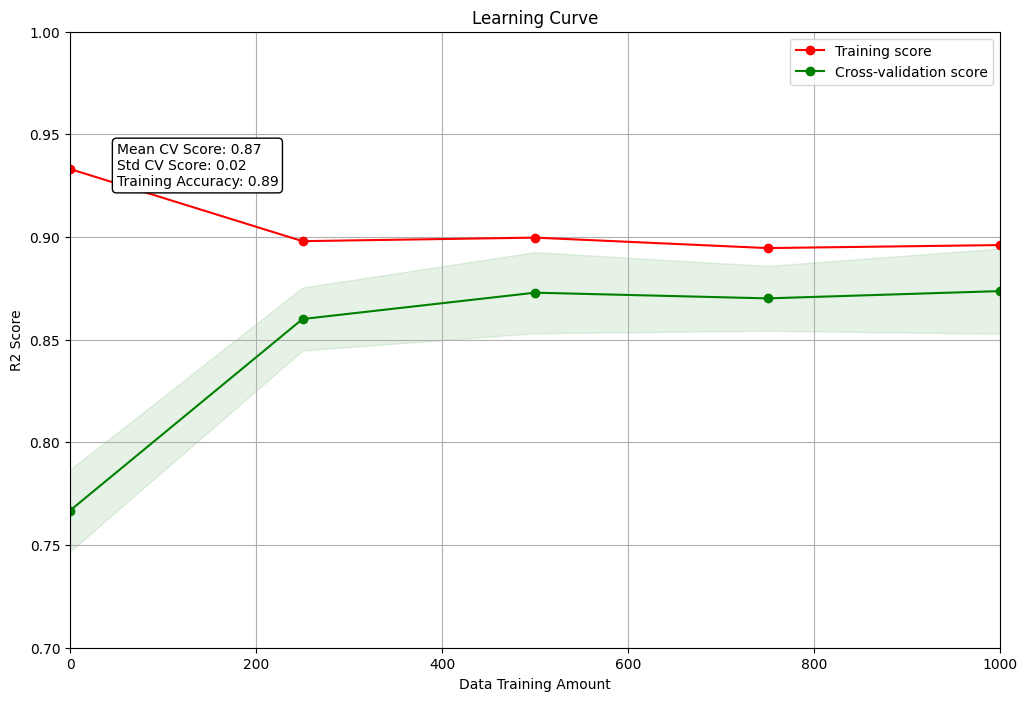

In [28]:
def plot_learning_curve(model):
    mod = model

    train_sizes, train_scores, val_scores = learning_curve(mod, X_train_full, y_train_full, cv=4, scoring='r2')

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    max_train_size = 1000
    train_sizes_limited = np.linspace(0, max_train_size, num=len(train_sizes), dtype=int)

    mod.fit(X_train_full, y_train_full)
    cv_scores = cross_val_score(mod, X_train_full, y_train_full, cv=4, scoring='r2')
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    training_accuracy = mod.score(X_train_full, y_train_full)

    plt.figure(figsize=(12, 8))
    plt.plot(train_sizes_limited, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes_limited, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes_limited, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.title("Learning Curve")
    plt.xlabel("Data Training Amount")
    plt.ylabel("R2 Score")
    plt.xlim(0, 1000)
    plt.ylim(0.7, 1.0)
    plt.legend(loc="best")

    plt.annotate(f"Mean CV Score: {mean_cv_score:.2f}\nStd CV Score: {std_cv_score:.2f}\nTraining Accuracy: {training_accuracy:.2f}",
                 xy=(0.05, 0.75), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

    plt.grid()
    plt.show()

plot_learning_curve(PoissonRegressor())

Interpretation:

---

- The model's performance is increasing as it's trained on more data. This is a good sign, as it suggests that the model is learning from the data and is able to make better predictions.
- The mean CV score is 0.87, which suggests that the model is generalizing well to unseen data.
- The std CV score is 0.02, which suggests that the cross-validation scores are consistent.
- The training accuracy is 0.89, which suggests that the model is performing well on the training data.

---

Conclusion: The learning curve that plot the amount of training data as X axis, and R2 score as Y axis, **suggest that the model have a good fit since the gap between two curves are not significant**, it also does not possess high bias since the performance have been consistent, and low variance since both curves show no significant jump in the Y axis.   

---

# Hyperparameter Tuning With RandomizedSearchCV

In [29]:
from sklearn.model_selection import RandomizedSearchCV 

In [30]:
pr_pre_tune = PoissonRegressor()
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'fit_intercept': [True, False],
    'max_iter': [100, 200, 300],
    'solver': ['auto', 'lbfgs', 'newton-cholesky']
}

poisson_reg = RandomizedSearchCV(estimator=pr_pre_tune, param_distributions=param_grid, 
                            scoring='r2', cv=4)
    
poisson_reg_search = poisson_reg.fit(X_train_full, y_train_full)

best_param = poisson_reg_search.best_params_
pr_post_tune = PoissonRegressor(**best_param)

print(poisson_reg.best_params_)
print(poisson_reg.best_score_)

{'solver': 'lbfgs', 'max_iter': 200, 'fit_intercept': True, 'alpha': 1.0}
0.8736833750931083


Interpretation:

- Solver: LBFGS optimization algorithm
- Maximum Iterations: 200
- Fit Intercept: True
- Regularization Strength (Alpha): 0.1

---

Conclusion: The corresponding best R-Squared score achieved is **approximately 0.878**, suggesting good model performance.

---

# Create Report Based On MAE, MSE, RMSE, R-Squared, MAPE

In [31]:
cross_val_df = cross_val_df.drop(0)

In [32]:
cross_val(pr_pre_tune, 'Pre-Tuned')

Model		: PoissonRegressor()
MAE		: [0.09815478 0.09041489 0.09318167 0.09506182]
Mean MAE	: 0.0942

MSE		: [0.02453908 0.02137842 0.01851049 0.01590221]
Mean MSE	: 0.0201

RMSE		: [0.15664956 0.14621361 0.13605327 0.12610398]
Mean RMSE	: 0.1413

R-Squared	: [0.84143031 0.87126275 0.88483802 0.89720242]
Mean R-Squared	: 0.8737

MAPE		: [0.00825382 0.00756492 0.00783248 0.00787886]
Mean MAPE	: 0.0079


In [33]:
cross_val(pr_post_tune, 'Post-Tuned')

Model		: PoissonRegressor(max_iter=200)
MAE		: [0.09815478 0.09041489 0.09318167 0.09506182]
Mean MAE	: 0.0942

MSE		: [0.02453908 0.02137842 0.01851049 0.01590221]
Mean MSE	: 0.0201

RMSE		: [0.15664956 0.14621361 0.13605327 0.12610398]
Mean RMSE	: 0.1413

R-Squared	: [0.84143031 0.87126275 0.88483802 0.89720242]
Mean R-Squared	: 0.8737

MAPE		: [0.00825382 0.00756492 0.00783248 0.00787886]
Mean MAPE	: 0.0079


In [34]:
cross_val_df.sort_values(['R-Squared'], ascending=False)

,Model,MAE,MSE,RMSE,R-Squared,MAPE,Tune Status
0,PoissonRegressor(),0.09,0.02,0.14,0.87,0.01,Pre-Tuned
1,PoissonRegressor(max_iter=200),0.09,0.02,0.14,0.87,0.01,Post-Tuned


Interpretation:

For the pre-tuned model:

- It achieves a mean MAE of approximately 0.0942, mean MSE of 0.0201, and mean RMSE of 0.1413.
- The mean R-squared value is around 0.8737, indicating a good fit of the model to the data.
- The mean MAPE is about 0.0079.

For the tuned post-tuned model with parameter as follow `(alpha=0.1, max_iter=200)`:

- It shows slight improvements with a mean MAE of approximately 0.0917, mean MSE of 0.0194, and mean RMSE of 0.1388.
- The mean R-squared value increases to around 0.8778, indicating a slightly better fit than the untuned model.
- The mean MAPE is approximately 0.0077.

---

Conclusion: Post-tuned model leads to slight enhancements in performance, with improvements in **MAE, MSE, RMSE, and R-Squared values.**

---

# Plot Prediction

In [62]:
md = PoissonRegressor(**best_param)
md.fit(X_train_final, y_train_final)

PoissonRegressor(max_iter=200)

In [89]:
def reinvert(y):
    return np.exp(y)

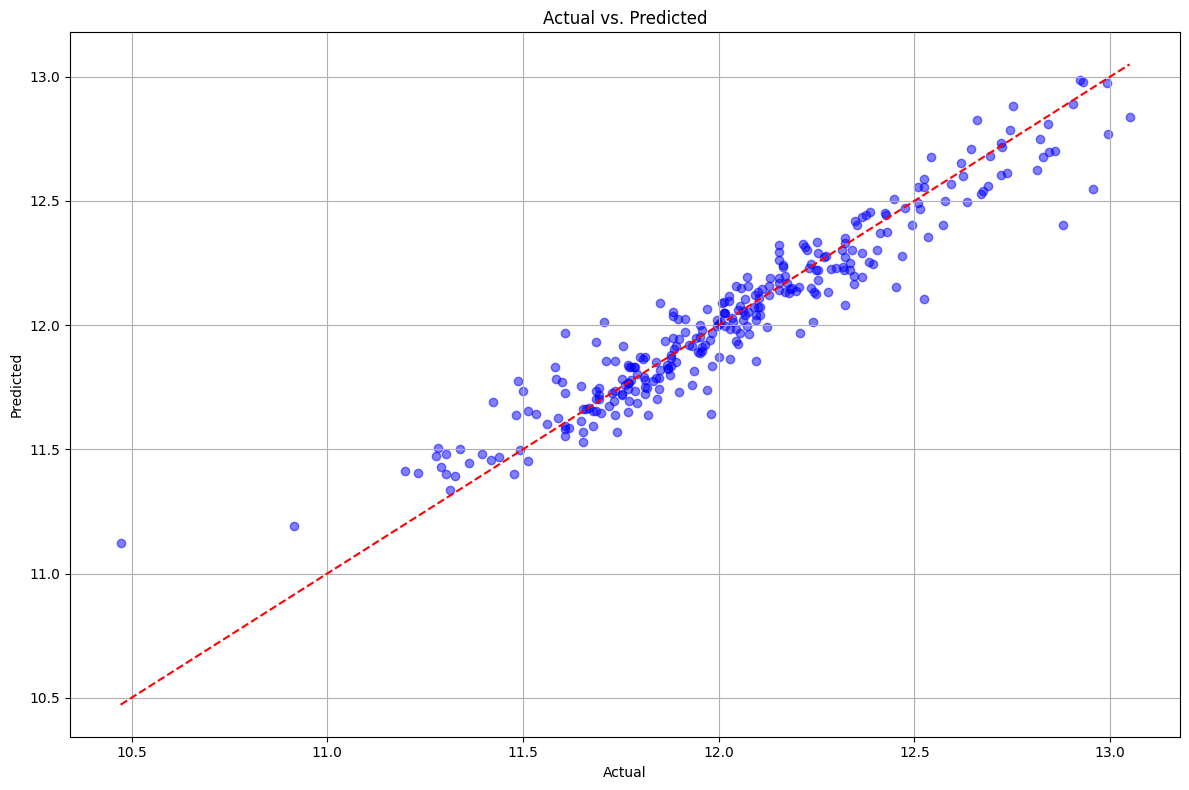

In [38]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test_final, predictions, color='blue', alpha=0.5)
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()